In [2]:
%%capture
%%pip install pulp
%%pip install seaborn

In [ ]:
from pulp import *
import pulp
import pandas as pd
import numpy as np
import random
from builtins import list
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:


# Lemos o ficheiro com os resultados das previsões dos produtos
df_productPredictions = pd.read_excel('../ml/results/results.xlsx')

# Verificamos o dataframe obtido
print(df_productPredictions.head())



  product_id                  model    rmse_sales  rmse_revenue     mae_sales  \
0      P0001       LinearRegression  4.885453e-01  2.578147e+00  4.041303e-01   
1      P0001  RandomForestRegressor  4.541629e+00  2.643378e+01  2.912128e+00   
2      P0001           XGBRegressor  3.921948e+00  2.690934e+01  2.526265e+00   
3      P0002       LinearRegression  1.218277e-15  2.703535e-14  1.016386e-15   
4      P0002  RandomForestRegressor  1.381411e+00  2.095142e+02  3.619048e-01   

    mae_revenue  r2_sales  r2_revenue  periodicity_total_pred_sales  \
0  2.147004e+00  0.999275    0.999468                            20   
1  1.623660e+01  0.937366    0.944062                            32   
2  1.796265e+01  0.953292    0.942031                            32   
3  1.974587e-14  1.000000    1.000000                             1   
4  6.351167e+01  0.380296    0.511473                             0   

   periodicity_total_pred_revenue  
0                          196.86  
1             

In [5]:


# Lemos o ficheiro com as dimensões dos produtos
df_productDimensions = pd.read_csv('../dataset/product_hierarchy.csv')

# Verificamos o dataframe obtido
print(df_productDimensions.head())



  product_id  product_length  product_depth  product_width cluster_id  \
0      P0000             5.0           20.0           12.0        NaN   
1      P0001            13.5           22.0           20.0  cluster_5   
2      P0002            22.0           40.0           22.0  cluster_0   
3      P0004             2.0           13.0            4.0  cluster_3   
4      P0005            16.0           30.0           16.0  cluster_9   

  hierarchy1_id hierarchy2_id hierarchy3_id hierarchy4_id hierarchy5_id  
0           H00         H0004       H000401     H00040105   H0004010534  
1           H01         H0105       H010501     H01050100   H0105010006  
2           H03         H0315       H031508     H03150800   H0315080028  
3           H03         H0314       H031405     H03140500   H0314050003  
4           H03         H0312       H031211     H03121109   H0312110917  


In [6]:


# Adicionamos uma nova coluna com a média de desempenho das previsões de receitas e vendas de cada modelo aplicado a cada produto
df_productPredictions['average_r2'] = (df_productPredictions['r2_sales'] + df_productPredictions['r2_revenue']) / 2

# Agrupamos os dados por produto, escolhendo apenas o modelo com a melhor média de desempenho das previsões, com o intuito de escolhermos os valores mais precisos
df_productPredictions = df_productPredictions.groupby('product_id').apply(lambda x: x.loc[x['average_r2'].idxmax()]).reset_index(level=0, drop=True)

# Verificamos a distribuição dos modelos escolhidos
print(df_productPredictions.model.value_counts().head())



LinearRegression         592
RandomForestRegressor      4
XGBRegressor               3
Name: model, dtype: int64


In [211]:


# Juntamos as dimensões dos produtos
df = pd.merge(df_productPredictions, df_productDimensions, left_on='product_id', right_on='product_id', how='left')

# Adicionamos uma nova coluna com as dimensões cúbicas (i.e. volume)
df['dimensions'] = (df['product_length'] * df['product_depth'] * df['product_width'])

# Removemos as colunas desnecessárias
df = df[['product_id', 'periodicity_total_pred_sales', 'periodicity_total_pred_revenue', 'dimensions']]
df = df.fillna(0)

# Verificamos o dataframe final
print(df.head())



  product_id  periodicity_total_pred_sales  periodicity_total_pred_revenue  \
0      P0001                            20                          196.86   
1      P0002                             1                          230.01   
2      P0004                             1                            0.85   
3      P0005                            12                          499.93   
4      P0006                             1                            0.00   

   dimensions  
0      5940.0  
1     19360.0  
2       104.0  
3      7680.0  
4      1912.5  


In [8]:
#-------------------------------User Input-------------------------------------

# Perguntamos pelos valores pretendidos para as restrições

# minAmountAllProducts = int(input("Por favor insira a quantidade mínima global de produtos: "))
# maxAmountAllProducts = int(input("Por favor insira a quantidade máxima global de produtos: "))

# minAmountPerProduct = int(input("Por favor insira a quantidade mínima de cada produto: "))
# maxAmountPerProduct  = int(input("Por favor insira a quantidade máxima de cada produto: "))

# minProductVariety = int(input("Por favor insira a variedade mínima de produtos: "))
# maxProductVariety  = int(input("Por favor insira a variedade máxima de produtos: "))

# storeDimensions  = int(input("Por favor insira as dimensões úteis da loja (i.e. volume): "))

In [217]:


# Alternativamente, configuramos as restrições sem input de utilizador para efeitos de análise
minAmountAllProducts = 10
maxAmountAllProducts = 100000
minAmountPerProduct = 0
maxAmountPerProduct  = 1000
minProductVariety = 0
maxProductVariety  = 250
storeDimensions = 10000000000



In [11]:


# Definimos as variáveis de decisão e auxiliares
def getVariables():
    chosenQuantityVars = [] # Inteira, decisão (Armazenará as quantidades escolhidas/ótimas por produto)
    isUsedVars = [] # Binária, auxiliar (Armazenará o valor 1 ou 0, caso o produto seja utilizado ou não, respetivamente)

    for product_id in df.product_id:
        # Aqui, aplicamos já as restrições mínimas e máximas de quantidades individuais, por produto
        chosenQuantityVars.append({product_id:  pulp.LpVariable(product_id, lowBound=minAmountPerProduct, upBound=maxAmountPerProduct,cat='Integer')})
        isUsedVars.append({product_id:  LpVariable(f'isUsed_{product_id}', cat='Binary')})
    
    return chosenQuantityVars, isUsedVars


# Verificamos o resultado para as configurações atuais
chosenQuantityVars, isUsedVars = getVariables()
print(len(chosenQuantityVars))
print(len(isUsedVars))



599
599


In [12]:

# Calcula as receitas previstas por unidade para um dado produto
def getExpectedRevenuePerUnit(product):
    expectedRevenuePerUnit = 0
    if product.periodicity_total_pred_sales > 0:
        expectedRevenuePerUnit = product.periodicity_total_pred_revenue / product.periodicity_total_pred_sales
    return expectedRevenuePerUnit

# Função objetivo
def getObjectiveFunction(decisionVars):
    model = 0
    for index, row in df.iterrows():
        model += (getExpectedRevenuePerUnit(row) * decisionVars[index][row.product_id])
    return model

# Criação do modelo ILP
model = pulp.LpProblem("ILP_Problem", pulp.LpMaximize)

# Adicionamos a função objetivo ao modelo
chosenQuantityVars, _ = getVariables()
model += getObjectiveFunction(chosenQuantityVars)

# Verificamos o modelo após adição da função objetivo
print(model)



ILP_Problem:
MAXIMIZE
9.843*P0001 + 230.01*P0002 + 0.85*P0004 + 41.660833333333336*P0005 + 10.0*P0007 + 5.385641025641026*P0008 + 5.394651162790698*P0009 + 108.86538461538461*P0012 + 4.641827411167513*P0015 + 1.7653571428571428*P0016 + 4.422730263157895*P0017 + 2.6721343873517784*P0018 + 0.01*P0021 + 29.0*P0022 + 35.275*P0025 + 5.636894736842105*P0026 + 29.050625*P0028 + 15.026666666666666*P0031 + 12.003333333333332*P0033 + 5.062861538461538*P0035 + 4.856181818181818*P0036 + 15.36734693877551*P0038 + 31.36976470588235*P0039 + 3.8814213197969543*P0042 + 24.58*P0043 + 6.6772413793103444*P0044 + 5.028095238095238*P0045 + 10.0*P0047 + 66.25*P0048 + 8.500714285714286*P0049 + 7.25*P0050 + 0.6300641025641026*P0051 + 17.52*P0053 + 7.822211538461539*P0054 + 5.689071428571428*P0055 + 5.764*P0057 + 0.85*P0058 + 15.124125000000001*P0059 + 20.631666666666668*P0060 + 20.43483695652174*P0061 + 5.633448275862069*P0063 + 50.01*P0065 + 0.76*P0066 + 24.41339285714286*P0067 + 4.18*P0068 + 8.24454545454545

In [13]:


# Função que aplica todas as restrições pretendidas para o modelo de otimização
def applyRestrictionsToModel(model, chosenQuantityVars, isUsedVars):
    # Aplicamos a restrição de quantidades globais mínimas e máximas dos produtos
    model += pulp.lpSum([chosenQuantityVars[index][row.product_id] for index, row in df.iterrows()]) <= maxAmountAllProducts
    model += pulp.lpSum([chosenQuantityVars[index][row.product_id] for index, row in df.iterrows()]) >= minAmountAllProducts

    # Aplicamos a restrição de dimensões globais máximas dos produtos, sendo que não deverão exceder as dimensões da loja
    model += pulp.lpSum([row.dimensions*chosenQuantityVars[index][row.product_id] for index, row in df.iterrows()]) <= storeDimensions

    # Aplicamos uma nova restrição de quantidades individuais máximas, consoante a previsão de unidades vendidas de cada produto, 
    # dado que todas as quantidades escolhidas que excedam esta previsão deixam de ser contabilizadas para as receitas e, portanto, devem ser descartadas.
    for index, row in df.iterrows():
        model += chosenQuantityVars[index][row.product_id] <= row.periodicity_total_pred_sales

    # Aplicamos a restrição de variedade globais mínimas e máximas dos produtos, sendo que para tal, iremos precisar de utilizar uma variável binária auxiliar para cada produto
    # que determine se o mesmo está a ser utilizado, isto é, se a sua quantidade escolhida for superior a 0
    for index, row in df.iterrows():
        model += (isUsedVars[index][row.product_id] * row.periodicity_total_pred_sales) >= chosenQuantityVars[index][row.product_id]
    model += pulp.lpSum([isUsedVars[index][row.product_id] for index, row in df.iterrows()]) <= maxProductVariety
    model += pulp.lpSum([isUsedVars[index][row.product_id] for index, row in df.iterrows()]) >= minProductVariety

# Verificamos as restrições
model = pulp.LpProblem("ILP_Problem", pulp.LpMaximize)
chosenQuantityVars, isUsedVars = getVariables()
model += getObjectiveFunction(chosenQuantityVars)
applyRestrictionsToModel(model, chosenQuantityVars, isUsedVars)
print(model)



ILP_Problem:
MAXIMIZE
9.843*P0001 + 230.01*P0002 + 0.85*P0004 + 41.660833333333336*P0005 + 10.0*P0007 + 5.385641025641026*P0008 + 5.394651162790698*P0009 + 108.86538461538461*P0012 + 4.641827411167513*P0015 + 1.7653571428571428*P0016 + 4.422730263157895*P0017 + 2.6721343873517784*P0018 + 0.01*P0021 + 29.0*P0022 + 35.275*P0025 + 5.636894736842105*P0026 + 29.050625*P0028 + 15.026666666666666*P0031 + 12.003333333333332*P0033 + 5.062861538461538*P0035 + 4.856181818181818*P0036 + 15.36734693877551*P0038 + 31.36976470588235*P0039 + 3.8814213197969543*P0042 + 24.58*P0043 + 6.6772413793103444*P0044 + 5.028095238095238*P0045 + 10.0*P0047 + 66.25*P0048 + 8.500714285714286*P0049 + 7.25*P0050 + 0.6300641025641026*P0051 + 17.52*P0053 + 7.822211538461539*P0054 + 5.689071428571428*P0055 + 5.764*P0057 + 0.85*P0058 + 15.124125000000001*P0059 + 20.631666666666668*P0060 + 20.43483695652174*P0061 + 5.633448275862069*P0063 + 50.01*P0065 + 0.76*P0066 + 24.41339285714286*P0067 + 4.18*P0068 + 8.24454545454545

In [14]:


# Função para executar o modelo de otimização
def runILP():
    model = pulp.LpProblem("ILP_Problem", pulp.LpMaximize)
    chosenQuantityVars, isUsedVars = getVariables()
    model += getObjectiveFunction(chosenQuantityVars)
    applyRestrictionsToModel(model, chosenQuantityVars, isUsedVars)
    status = model.solve()
    return model, status, chosenQuantityVars

# Executamos o modelo de otimização
model, status, chosenQuantityVars = runILP()
# Verificamos o sucesso do modelo, isto é, se conseguiu obter uma solução ótima
print(f"Resultado do Modelo: {pulp.LpStatus[status]}")

# Verificamos a solução obtida pelo modelo, isto é, as receitas previstas para as quantidades escolhidas
print(f"\nTotal de Receitas Previstas: \n{round(pulp.value(model.objective), 2)}$")



Resultado do Modelo: Optimal

Total de Receitas Previstas: 
82408.19$


In [15]:


# Criamos um dataframe onde iremos armazenar os resultados deste modelo, para futuramente comparar com os resultados obtidos no algoritmo genético
model_ilp_results = pd.DataFrame(columns=["product_id", "quantidadeOtima"])

# Verificamos as quantidades escolhidas pelo modelo para cada produto
for index, row in df.iterrows():
    model_ilp_results = pd.concat([model_ilp_results,  pd.DataFrame.from_records([{"product_id": row.product_id, "quantidadeOtima": pulp.value(chosenQuantityVars[index][row.product_id])}])])

print(model_ilp_results.head(25))


  product_id  quantidadeOtima
0      P0001              0.0
0      P0002              0.0
0      P0004              0.0
0      P0005              0.0
0      P0006              0.0
0      P0007              0.0
0      P0008              0.0
0      P0009              0.0
0      P0010              0.0
0      P0011              0.0
0      P0012              0.0
0      P0014              0.0
0      P0015              0.0
0      P0016              0.0
0      P0017              0.0
0      P0018              0.0
0      P0021              0.0
0      P0022              0.0
0      P0024              0.0
0      P0025              0.0
0      P0026              0.0
0      P0028             16.0
0      P0029              0.0
0      P0031              3.0
0      P0033              0.0


----------- Genetic Algorithm -------------

    Restritions:
    

Restrictions functions return 1 respected, 0 if not respected


In [206]:


# Validação das quantidades escolhidas de um indíviduo perante as restrições de quantidades globais máximas e mínimas
# Caso o indíviduo esteja válido, retorna 0
# Caso o indíviduo esteja inválido, retorna a diferença de quantidades, para que estes sejam posteriormente ajustadas
def validateGlobalAmounts(ind):
    somaTotalAmountIndividuo = sum(ind)
    if somaTotalAmountIndividuo < minAmountAllProducts:
        return somaTotalAmountIndividuo - minAmountAllProducts
    if somaTotalAmountIndividuo > maxAmountAllProducts:
        return somaTotalAmountIndividuo - maxAmountAllProducts
    return 0

# Validação das dimensões de um indíviduo perante as restrições de dimensões máximas globais, isto é, da loja
# Caso o indíviduo esteja válido, retorna 0
# Caso o indíviduo esteja inválido, retorna a diferença de dimensões, para que estes sejam posteriormente ajustadas
def validateDimensions(ind):
    sumDimensions = 0
    for index, row in df.iterrows():
        sumDimensions += ind[index] * row.dimensions
    if(sumDimensions > storeDimensions):
        return sumDimensions - storeDimensions
    return 0

# Validação de um indivíduo perante todas as restrições existentes
# Returna 0 se for válido
# Returna 1 se for inválido
def validateInd(ind):
    globalAmountsValidation = validateGlobalAmounts(ind)
    dimensionsValidation = validateDimensions(ind)
    if (globalAmountsValidation != 0 | dimensionsValidation != 0):
        return 1
    return 0

def adjustQuantities(ind, diff_quant):
    indWithPredictions = pd.DataFrame(df, columns=["periodicity_total_pred_sales",  "periodicity_total_pred_revenue"])
    indWithPredictions['chosen_quantity'] = ind
    # Armazenamos a diferença entre a quantidade prevista de vendas e a quantidade escolhida
    # Exemplo: 
    # Quantidade Prevista = 10
    # Quantidade Escolhida = 5
    # Diferença = 10 - 5 = 5
    indWithPredictions['quantity_diff'] = indWithPredictions['periodicity_total_pred_sales'] - indWithPredictions['chosen_quantity']
    # Preservamos os indíces antigos, dado que este dataframe será reordenado
    indWithPredictions = indWithPredictions.assign(index_col = indWithPredictions.index)
    
    # Se existirem quantidades globais em excesso então iremos remover
    if diff_quant > 0:
        # Ordenamos os produtos por ordem ascendente dos que têm mais quantidades em excesso (> Quantidades Previstas)
        # e, de seguida, pelos que têm menos receitas previstas dado que iremos remover quantidades
        indWithPredictions = indWithPredictions.sort_values(by=['quantity_diff', 'periodicity_total_pred_revenue'], ascending=[True, True])
        i = 0
        while diff_quant > 0 & i < len(indWithPredictions):
            row = indWithPredictions.iloc[i]
            quantityToAdjust = abs(row['quantity_diff'])
            if quantityToAdjust > diff_quant:
                quantityToAdjust = diff_quant
            ind[int(row.index_col)] -= int(quantityToAdjust)
            diff_quant -= quantityToAdjust
            i += 1
    # Se existirem quantidades globais em falta então iremos adicionar
    if diff_quant < 0:
        # Ordenamos os produtos por ordem descendente dos que têm mais quantidades em falta (< Quantidades Previstas) 
        # e, de seguida, pelos que têm mais receitas previstas dado que iremos adicionar quantidades
        indWithPredictions = indWithPredictions.sort_values(by=['quantity_diff', 'periodicity_total_pred_revenue'], ascending=[False, False])
        i = 0
        while diff_quant < 0 & i < len(indWithPredictions):
            row = indWithPredictions.iloc[i]
            quantityToAdjust = abs(row['quantity_diff'])
            if quantityToAdjust > abs(diff_quant):
                quantityToAdjust = abs(diff_quant)
            ind[int(row.index_col)] += int(quantityToAdjust)
            diff_quant += quantityToAdjust
            i += 1
    
    return ind



Creation of First Population

Evaluation Function

In [218]:

# Função para a criação da primeira população
def createFirstPop(popSize):
    pop = []
    while len(pop) < popSize:
        solution = []
        totalQuantity = 0
        totalDimension = 0
        
        #generates the chromossomes each representing one product
        for j in range(len(df)):
            quantity = random.randint(minAmountPerProduct, round((maxAmountPerProduct / 3)))
            solution.append(quantity)

        globalAmountsValidation = validateGlobalAmounts(solution)
        dimensionsValidation = validateDimensions(solution)
        if (globalAmountsValidation == 0) and (dimensionsValidation == 0):
            pop.append(solution)
        
    return pop

# Verificamos a criação da primeira população para 5 indíviduos
print(createFirstPop(1))



[[113, 51, 21, 155, 209, 69, 212, 51, 39, 54, 199, 150, 149, 251, 259, 306, 102, 111, 140, 131, 61, 204, 57, 216, 175, 12, 230, 262, 140, 21, 46, 47, 288, 302, 146, 125, 281, 275, 98, 130, 333, 321, 260, 310, 330, 71, 284, 95, 133, 14, 31, 228, 249, 151, 107, 49, 69, 86, 209, 177, 261, 114, 116, 55, 94, 154, 93, 177, 217, 319, 315, 203, 61, 146, 263, 330, 303, 66, 126, 82, 266, 57, 168, 265, 132, 296, 296, 95, 54, 40, 123, 229, 117, 158, 25, 249, 252, 316, 192, 154, 106, 89, 160, 225, 257, 191, 186, 252, 144, 221, 28, 17, 159, 238, 168, 156, 144, 185, 226, 135, 240, 158, 330, 333, 329, 40, 48, 128, 112, 95, 204, 78, 45, 82, 319, 230, 137, 217, 112, 148, 45, 127, 281, 78, 122, 19, 292, 43, 116, 245, 117, 173, 51, 150, 237, 1, 324, 150, 78, 151, 111, 3, 215, 260, 139, 2, 277, 91, 149, 97, 58, 23, 101, 84, 189, 288, 163, 47, 57, 134, 198, 71, 31, 293, 67, 245, 158, 295, 249, 275, 135, 309, 238, 321, 144, 149, 45, 8, 164, 66, 83, 199, 158, 283, 169, 48, 78, 100, 143, 277, 315, 202, 155, 20

In [219]:


# Calcula as receitas previstas de um produto tendo em consideração a quantidade escolhida e a quantidade prevista
def getPredictedProfit(productIndex, chosenQuantity):
    product = df.iloc[productIndex]
    if product.periodicity_total_pred_sales == 0:
        return 0
    return min(product.periodicity_total_pred_revenue, (product.periodicity_total_pred_revenue / product.periodicity_total_pred_sales) * chosenQuantity)

# Verificamos as receitas previstas para o primeiro produto, tendo em conta vários valores diferentes, sendo que deverá limitar as receitas consoante as unidades vendidas previstas
print(f"Unidades Vendidas Previstas do Produto {df.iloc[0].product_id}: {df.iloc[0].periodicity_total_pred_sales}")
print(f"Receitas Previstas para 5 unidades escolhidas: {getPredictedProfit(0, 5)}")
print(f"Receitas Previstas para 10 unidades escolhidas: {getPredictedProfit(0, 10)}")
print(f"Receitas Previstas para 15 unidades escolhidas: {getPredictedProfit(0, 15)}")
print(f"Receitas Previstas para 20 unidades escolhidas: {getPredictedProfit(0, 20)}")
print(f"Receitas Previstas para 25 unidades escolhidas: {getPredictedProfit(0, 25)}")




Unidades Vendidas Previstas do Produto P0001: 20
Receitas Previstas para 5 unidades escolhidas: 49.215
Receitas Previstas para 10 unidades escolhidas: 98.43
Receitas Previstas para 15 unidades escolhidas: 147.645
Receitas Previstas para 20 unidades escolhidas: 196.86
Receitas Previstas para 25 unidades escolhidas: 196.86


In [220]:

# Função que avalia uma população, atribuindo valores de avaliação a cada indíviduo conforme as receitas previstas para as respetivas quantidades escolhidas
def evaluatePop(pop):
    popEvaluated = []
    for ind in pop:
        indExpectedRevenue = 0
        for index, chosenQuantity in enumerate(ind):
            indExpectedRevenue += getPredictedProfit(index, chosenQuantity)
        popEvaluated.append({ 'individuo': ind, 'calculatedProfit': indExpectedRevenue })
    return popEvaluated

# Verificamos a função de avaliação de populações
firstPop = createFirstPop(1)
print(evaluatePop(firstPop))


[{'individuo': [41, 69, 154, 322, 15, 243, 132, 246, 114, 14, 136, 137, 79, 90, 140, 203, 320, 138, 128, 258, 220, 231, 86, 147, 235, 294, 129, 326, 253, 163, 314, 210, 41, 186, 240, 228, 325, 139, 185, 169, 81, 84, 109, 31, 112, 200, 323, 57, 211, 291, 3, 282, 90, 44, 192, 34, 99, 171, 312, 45, 109, 309, 52, 186, 311, 70, 120, 107, 16, 236, 258, 257, 86, 194, 326, 120, 249, 313, 133, 132, 119, 178, 75, 93, 43, 255, 154, 277, 183, 91, 141, 13, 40, 75, 4, 197, 267, 167, 310, 51, 286, 70, 117, 20, 243, 195, 179, 218, 312, 108, 175, 178, 124, 100, 17, 216, 245, 118, 5, 200, 72, 255, 47, 147, 251, 263, 248, 83, 71, 326, 29, 181, 279, 178, 175, 64, 146, 184, 199, 87, 32, 266, 131, 18, 85, 106, 24, 86, 127, 57, 75, 121, 34, 27, 235, 74, 35, 8, 125, 16, 13, 158, 14, 232, 38, 121, 215, 308, 246, 300, 184, 78, 144, 269, 307, 65, 92, 51, 224, 319, 4, 5, 3, 109, 216, 27, 171, 8, 84, 50, 275, 322, 22, 209, 256, 206, 3, 126, 155, 178, 199, 31, 50, 189, 63, 123, 67, 138, 187, 281, 94, 229, 204, 45, 

Crossover

In [221]:


# Função para ordenar os indivíduos de uma população consoante a sua avaliação
def getPopOrderedByEvaluation(popEvaluated):
    popEvaluatedOrdered = sorted(popEvaluated, key=lambda x: x['calculatedProfit'], reverse=True)
    return [x['individuo'] for x in popEvaluatedOrdered]

# Verificamos a função de ordenação de populações
firstPop = createFirstPop(1)
firstPopEvaluated = evaluatePop(firstPop)
print(getPopOrderedByEvaluation(firstPopEvaluated))



[[238, 38, 36, 161, 135, 163, 172, 163, 110, 82, 215, 268, 59, 174, 44, 81, 45, 247, 130, 209, 158, 70, 254, 149, 217, 193, 158, 155, 120, 177, 238, 192, 8, 118, 232, 8, 49, 9, 177, 108, 316, 248, 249, 96, 180, 200, 53, 221, 113, 80, 71, 178, 69, 150, 264, 263, 105, 102, 126, 59, 273, 148, 269, 94, 291, 300, 323, 283, 192, 56, 304, 17, 17, 62, 303, 126, 225, 329, 204, 29, 129, 228, 252, 274, 148, 109, 307, 141, 248, 54, 33, 240, 2, 120, 224, 93, 127, 287, 162, 275, 209, 222, 116, 166, 6, 51, 73, 76, 141, 333, 45, 172, 217, 203, 11, 208, 40, 77, 7, 322, 319, 64, 279, 221, 160, 108, 190, 27, 133, 328, 145, 147, 71, 257, 118, 32, 19, 333, 124, 312, 111, 298, 39, 325, 2, 206, 237, 331, 312, 301, 124, 111, 253, 125, 314, 264, 43, 28, 69, 318, 226, 258, 85, 145, 181, 246, 193, 127, 74, 195, 315, 279, 247, 236, 222, 319, 246, 142, 304, 170, 126, 120, 117, 299, 251, 4, 90, 137, 174, 207, 232, 183, 53, 330, 182, 305, 327, 4, 170, 213, 199, 312, 132, 185, 301, 203, 108, 103, 311, 38, 246, 23, 27

In [225]:


# Função que devolve a lista de indíviduos de uma população para os quais será aplicado o crossover, 
# sendo o respetivo tamanho calculado de acordo com a taxa de crossover configurada
def selectIndsToCrossover(pop, crossoverTax):
    # Cruzamos os primeiros/melhores n indivíduos, consoante a taxa de cruzamento
    nElementsToCrossover = round(len(pop) * (crossoverTax / 100))
    # Preenchemos o espaço restante com os primeiros/melhores indivíduos
    nElementsToMaintain = len(pop) - nElementsToCrossover
    return pop[:nElementsToMaintain], pop[:nElementsToCrossover]

# Função que aplica o crossover a uma lista de indíviduos, devolvendo a lista de indivíduos cruzada
def crossoverListInds(indsToCrossover):
    inds = []
    while len(indsToCrossover) > 0:
        # Se só restar um indíviduo, isto é, se a lista de indíviduos era ímpar, então adiciona o último indíviduo, sem este ser cruzado
        # Caso contrário, é aplicado o crossover entre dois indíviduos escolhidos aleatoriamente
        if len(indsToCrossover) == 1:
            inds.append(indsToCrossover[0])
            indsToCrossover.pop()
        else:
            # Escolhe dois indíviduos aleatoriamente, entre os quais será efetuado o cruzamento
            indexInd1 = random.randint(0, len(indsToCrossover) - 1)
            indexInd2 = indexInd1
            while indexInd1 == indexInd2:
                indexInd2 = random.randint(0, len(indsToCrossover) - 1)
            
            ind1 = indsToCrossover[indexInd1]
            ind2 = indsToCrossover[indexInd2]
            
            crossoverPoint = random.randint(1, len(indsToCrossover[indexInd1]) - 1)
            for i in list(range(crossoverPoint)):
                aux = ind1[i]
                ind1[i] = ind2[i]
                ind2[i] = aux

            globalAmountValidation = validateGlobalAmounts(ind1) 
            while globalAmountValidation != 0:
                adjustQuantities(ind1, globalAmountValidation)
                globalAmountValidation = validateGlobalAmounts(ind1)

            globalAmountValidation = validateGlobalAmounts(ind2) 
            while globalAmountValidation != 0:
                adjustQuantities(ind2, globalAmountValidation)
                globalAmountValidation = validateGlobalAmounts(ind2)

            inds.append(ind1)
            inds.append(ind2)
            indsToCrossover.pop(max(indexInd1, indexInd2))
            indsToCrossover.pop(min(indexInd1, indexInd2))
    return inds

# Função que aplica o crossover a uma população, devolvendo a mesma após o cruzamento dos respetivos indivíduos
def crossover(pop, crossoverTax):
    pop = getPopOrderedByEvaluation(pop)
    indsToMaintain, indsToCrossover = selectIndsToCrossover(pop, crossoverTax)
    indsToCrossover = crossoverListInds(indsToCrossover)
    return indsToMaintain + indsToCrossover

# Verificamos o crossover de indivíduos de uma população
pop = createFirstPop(1)
pop = evaluatePop(pop)
print(crossover(pop, 70))


[[111, 303, 161, 271, 195, 103, 15, 175, 266, 206, 291, 133, 87, 208, 52, 114, 167, 238, 328, 184, 251, 32, 119, 221, 164, 261, 124, 82, 313, 310, 83, 39, 233, 62, 3, 60, 9, 121, 25, 54, 280, 212, 258, 201, 326, 134, 228, 84, 282, 63, 130, 33, 243, 206, 196, 259, 116, 142, 298, 113, 136, 324, 178, 120, 196, 39, 15, 325, 152, 286, 144, 277, 117, 6, 18, 15, 172, 291, 287, 62, 48, 112, 243, 257, 236, 49, 271, 115, 262, 8, 261, 28, 59, 204, 119, 230, 68, 184, 138, 13, 321, 280, 10, 219, 35, 303, 241, 223, 85, 294, 101, 88, 105, 274, 33, 170, 247, 99, 77, 91, 6, 34, 259, 234, 200, 229, 252, 109, 181, 325, 84, 77, 246, 17, 69, 80, 50, 48, 29, 90, 69, 147, 114, 265, 155, 168, 221, 214, 325, 149, 258, 27, 92, 32, 118, 209, 308, 45, 138, 23, 281, 247, 75, 65, 274, 329, 326, 196, 37, 300, 252, 225, 224, 170, 278, 331, 84, 138, 153, 200, 104, 255, 27, 332, 131, 11, 125, 324, 289, 174, 78, 176, 289, 162, 33, 188, 196, 124, 133, 83, 333, 292, 61, 212, 35, 153, 81, 159, 127, 42, 198, 86, 237, 183, 1

Mutation

In [226]:


# Função que devolve a lista de indíviduos de uma população para os quais será aplicada mutação, 
# sendo o respetivo tamanho calculado de acordo com a taxa de mutação configurada
def selectIndsToMutate(pop, taxMutation):
    indsToMutate = []
    indsToMaintain = []
    for ind in pop:
        t = random.randint(0, 100)
        if t <= taxMutation:
            indsToMutate.append(ind)
        else:
            indsToMaintain.append(ind)
    return indsToMaintain, indsToMutate

# Função que aplica mutação a uma lista de indíviduos, devolvendo a lista de indivíduos mutada
def mutateListInds(indsToMutate, taxChangeGene):
    inds = indsToMutate.copy()
    for ind in inds:
        # Escolhemos aleatoriamente o gene (quantidade de um produto) que será mutado
        index = random.randint(0, len(ind) - 1)
        # Escolhemos aleatoriamente se a mutação será do tipo redução ou acréscimo de quantidade
        mutateUpperOrLower = random.randint(0, 1)

        # Calculamos a mutação que será aplicada ao gene, sendo esta negativa caso se trate de uma redução
        changeInGene = round(ind[index] * (taxChangeGene / 100))
        if(mutateUpperOrLower == 0):
            changeInGene *= -1

        ind1 = ind.copy()
        ind1[index] = ind[index] + changeInGene
        # Caso o indíviduo deixe de ser válido após a mutação, então esta é reduzida em metade consecutivamente 
        # até que o indivíduo seja válido ou até que a mutação deixe de ser possível
        while changeInGene > 0 & validateInd(ind1) == 1: 
            changeInGene = round(changeInGene / 2)
            ind1[index] = ind[index] + changeInGene
        ind[index] = ind1[index]
           
    return inds

# Função que aplica mutation a uma população, devolvendo a mesma após a mutação dos respetivos indivíduos
def mutation(pop, taxMutation, taxChangeGene):
    indsToMaintain, indsToMutate = selectIndsToMutate(pop, taxMutation)
    indsToMutate = mutateListInds(indsToMutate, taxChangeGene)
    return indsToMaintain + indsToMutate


# Verificamos a mutação de indivíduos de uma população
pop = createFirstPop(1)
print(mutation(pop, 10, 20))



[[13, 54, 181, 17, 131, 298, 269, 1, 208, 149, 200, 54, 253, 239, 140, 70, 273, 317, 39, 117, 222, 92, 255, 197, 238, 299, 13, 224, 99, 55, 10, 198, 188, 189, 257, 273, 131, 264, 189, 50, 161, 316, 221, 228, 167, 140, 29, 101, 239, 10, 265, 98, 333, 188, 268, 219, 21, 52, 130, 300, 74, 259, 24, 98, 273, 291, 175, 263, 16, 32, 111, 212, 190, 198, 135, 41, 101, 233, 108, 265, 217, 275, 16, 55, 61, 285, 279, 88, 262, 115, 31, 289, 83, 226, 105, 48, 163, 134, 265, 329, 88, 86, 235, 162, 100, 173, 249, 132, 9, 0, 125, 272, 43, 298, 137, 265, 311, 223, 0, 37, 27, 320, 328, 309, 206, 311, 171, 191, 278, 289, 291, 24, 101, 233, 272, 300, 298, 264, 275, 59, 306, 144, 189, 196, 202, 210, 201, 49, 271, 297, 295, 247, 233, 21, 55, 251, 35, 126, 134, 47, 299, 300, 42, 65, 3, 46, 51, 28, 132, 110, 3, 1, 170, 97, 64, 108, 219, 327, 301, 307, 60, 4, 107, 140, 77, 49, 295, 50, 78, 160, 18, 333, 210, 88, 0, 22, 66, 287, 184, 11, 152, 69, 232, 210, 264, 25, 5, 164, 124, 315, 167, 40, 323, 267, 39, 257, 8

Iterate multiple times

In [230]:

# Função que retorna o melhor indivíduo de uma população
def getBestInd(pop):
    popEvaluated = evaluatePop(pop)
    bestInd = max(popEvaluated, key=lambda x: x['calculatedProfit'])
    return bestInd

# Função que gera uma nova população a partir da geração anterior
def generatePopulation(previousGen, crossoverTax, taxMutation, taxChangeGene):
    pop = previousGen.copy()
    pop = evaluatePop(pop)
    pop = crossover(pop, crossoverTax)
    pop = mutation(pop, taxMutation, taxChangeGene)
    return pop

# Função que executa o algoritmo genético perante as configurações e condições de término pretendidas
def runGeneticAlgorithm(popSize, crossoverTax, taxMutation, taxChangeGene, maxGenerations, maxTime, optimalSolution):
    generations = []
    bestInds = []
    nGen = 1
    start_time = time.time()
    while nGen <= maxGenerations:
        # Verificamos se o tempo máximo de duração de execução configurado já foi excedido
        timeSpent = (time.time() - start_time)
        if (time.time() - start_time) >= maxTime:
            print(f"Algoritmo genético finalizado por condição de término --> Tempo - {timeSpent}s") 
            return generations
        
        # Geramos uma nova população
        newPop = []
        if nGen == 1:
            newPop = createFirstPop(popSize)
        else:
            newPop = generatePopulation(generations[nGen - 2], crossoverTax, taxMutation, taxChangeGene)
        generations.append(newPop)

        # Apresentamos o melhor indivíduo da nova população
        bestInd = getBestInd(newPop)
        print(f"Geração {nGen} --> Melhor Indivíduo - {round(bestInd['calculatedProfit'], 2)}$") 

        # Verificamos se já foi atingida a solução ótima
        if bestInd['calculatedProfit'] >= optimalSolution:
            print(f"Algoritmo genético finalizado por condição de término --> Solução Ótima - {round(bestInd['calculatedProfit'], 2)}$") 
            return generations
        
        nGen += 1
    print(f"Algoritmo genético finalizado por condição de término --> Limite de Gerações - {nGen}")
    return generations

# Restrições
minAmountAllProducts = 10
maxAmountAllProducts = 100000
minAmountPerProduct = 0
maxAmountPerProduct  = 1000
minProductVariety = 0
maxProductVariety  = 250
storeDimensions = 10000000000

# Configurações
popSize = 30
crossoverTax = 80
taxMutation = 8
taxChangeGene = 10

# Condições de Término
maxGenerations = 100
maxTime = 60
optimalSolution = 300000

# Testamos o algoritmo genético para as configurações acima apresentadas
print(len(runGeneticAlgorithm(popSize, crossoverTax, taxMutation, taxChangeGene, maxGenerations, maxTime, optimalSolution)))

Geração 1 --> Melhor Indivíduo - 255668.25$
Geração 2 --> Melhor Indivíduo - 256498.25$
Geração 3 --> Melhor Indivíduo - 255429.55$
Geração 4 --> Melhor Indivíduo - 262620.4$
Geração 5 --> Melhor Indivíduo - 266086.95$
Geração 6 --> Melhor Indivíduo - 256502.26$
Geração 7 --> Melhor Indivíduo - 258375.53$
Geração 8 --> Melhor Indivíduo - 261869.04$
Geração 9 --> Melhor Indivíduo - 267645.89$
Geração 10 --> Melhor Indivíduo - 263474.94$
Geração 11 --> Melhor Indivíduo - 264020.94$
Geração 12 --> Melhor Indivíduo - 268214.52$
Geração 13 --> Melhor Indivíduo - 271906.64$
Geração 14 --> Melhor Indivíduo - 265947.22$
Geração 15 --> Melhor Indivíduo - 267615.52$
Geração 16 --> Melhor Indivíduo - 265301.69$
Geração 17 --> Melhor Indivíduo - 265011.07$
Geração 18 --> Melhor Indivíduo - 265011.07$
Algoritmo genético finalizado por condição de término --> Tempo - 61.13710045814514s
18


Geração 1 --> Melhor Indivíduo - 251740.08$
Geração 2 --> Melhor Indivíduo - 255149.72$
Geração 3 --> Melhor Indivíduo - 258142.01$
Geração 4 --> Melhor Indivíduo - 255084.52$
Geração 5 --> Melhor Indivíduo - 256947.11$
Geração 6 --> Melhor Indivíduo - 258018.64$
Algoritmo genético finalizado por condição de término --> Tempo - 22.200791358947754s
[]
Geração 1 --> Melhor Indivíduo - 259943.28$
Geração 2 --> Melhor Indivíduo - 255674.57$
Geração 3 --> Melhor Indivíduo - 259369.41$
Geração 4 --> Melhor Indivíduo - 255922.3$
Geração 5 --> Melhor Indivíduo - 261617.89$
Algoritmo genético finalizado por condição de término --> Tempo - 20.279757499694824s
[]
Geração 1 --> Melhor Indivíduo - 261435.63$
Geração 2 --> Melhor Indivíduo - 261109.19$
Geração 3 --> Melhor Indivíduo - 261109.19$
Geração 4 --> Melhor Indivíduo - 257525.54$
Geração 5 --> Melhor Indivíduo - 260585.54$
Geração 6 --> Melhor Indivíduo - 258373.35$
Algoritmo genético finalizado por condição de término --> Tempo - 23.819676

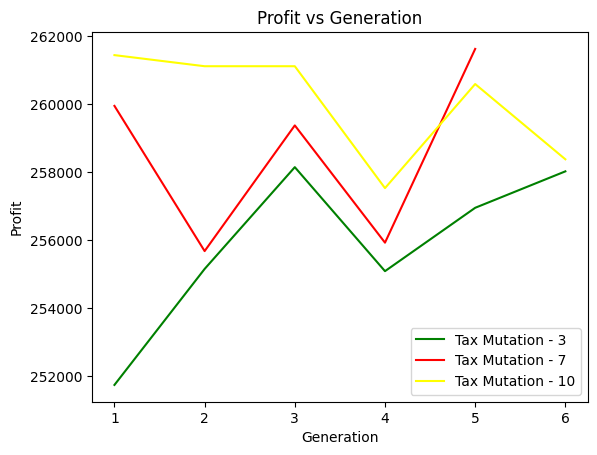

In [ ]:
generations, bestInds = runGeneticAlgorithm(popSize, crossoverTax, 2, taxChangeGene, maxGenerations, maxTime, optimalSolution)
generations, bestInds1 = runGeneticAlgorithm(popSize, crossoverTax, 9, taxChangeGene, maxGenerations, maxTime, optimalSolution)
generations, bestInds2 = runGeneticAlgorithm(popSize, crossoverTax, 15, taxChangeGene, maxGenerations, maxTime, optimalSolution)

revenueList = []

count = 0
for bestInd in bestInds:
    revenueList.append(bestInd['calculatedProfit'])
    
indexList = []
count = 0
for i in range(len(revenueList)):
    count+=1
    indexList.append(count)

teste = pd.DataFrame(revenueList)
teste['Generation'] = indexList
teste = teste.rename(columns={0:'Profit'})


revenueList1 = []

for bestInd in bestInds1:
    revenueList1.append(bestInd['calculatedProfit'])
    
indexList1 = []
count1 = 0
for i in range(len(revenueList1)):
    count1+=1
    indexList1.append(count1)

teste1= pd.DataFrame(revenueList1)
teste1['Generation'] = indexList1
teste1 = teste1.rename(columns={0:'Profit'})


revenueList2 = []

for bestInd in bestInds2:
    revenueList2.append(bestInd['calculatedProfit'])
    
indexList2 = []
count2 = 0
for i in range(len(revenueList2)):
    count2+=1
    indexList2.append(count2)

teste2= pd.DataFrame(revenueList2)
teste2['Generation'] = indexList2
teste2 = teste2.rename(columns={0:'Profit'})

# ------------------------------------------------------------------------------------

# # Plot the first line
ax = teste.plot(x='Generation', y='Profit', kind='line', label='Tax Mutation - 3', color='green')
teste1.plot(x='Generation', y='Profit', kind='line', label='Tax Mutation - 7', color='red', ax=ax)
teste2.plot(x='Generation', y='Profit', kind='line', label='Tax Mutation - 10', color='yellow', ax=ax)
# # Plot the second line on the same axes

# # Add a x and y label
plt.xlabel("Generation")
plt.ylabel("Profit")

# # Add a title
plt.title("Profit vs Generation")

# # Add a legend
plt.legend()

# # Show the plot
plt.show()

In [ ]:
print(revenueList)
# print(generations)
indexList = []
count = 0
for i in range(len(revenueList)):
    count+=1
    indexList.append(count)

[250785.95801201384, 251993.01445324728, 254660.25042780826, 257246.94241178202, 258518.33818323267, 255320.3116666269]
